# Project 1: End-to-End Pipeline to Classify News Articles

## Question 1

### 1.1 Overview How many rows (samples) and columns (features) are present in the dataset?

In [1]:
import pandas as pd

df = pd.read_csv('Project1-ClassificationDataset.csv')

num_rows, num_cols = df.shape

print(f"Number of rows (samples): {num_rows}")
print(f"Number of cols (features): {num_cols}")

Number of rows (samples): 3476
Number of cols (features): 8


### 1.2 Histograms

#### (a) The total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis

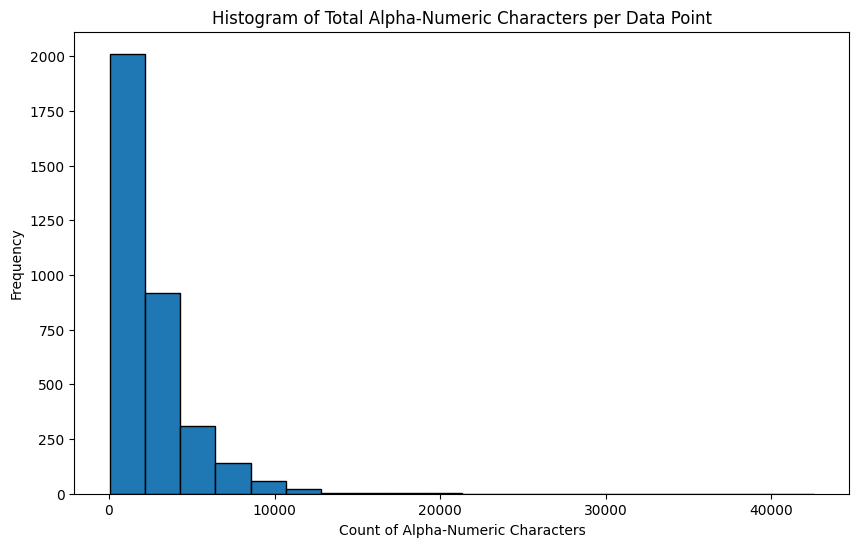

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV file into a DataFrame
file_path = 'Project1-ClassificationDataset.csv'
df = pd.read_csv(file_path)

# (a) Histogram for the total number of alpha-numeric characters per data point
df['Total_AlphaNumeric_Count'] = df['full_text'].apply(lambda x: sum(c.isalnum() for c in str(x)))
plt.figure(figsize=(10, 6))
plt.hist(df['Total_AlphaNumeric_Count'], bins=20, edgecolor='black')
plt.title('Histogram of Total Alpha-Numeric Characters per Data Point')
plt.xlabel('Count of Alpha-Numeric Characters')
plt.ylabel('Frequency')
plt.show()

#### (b) The column leaf label – class on the x-axis

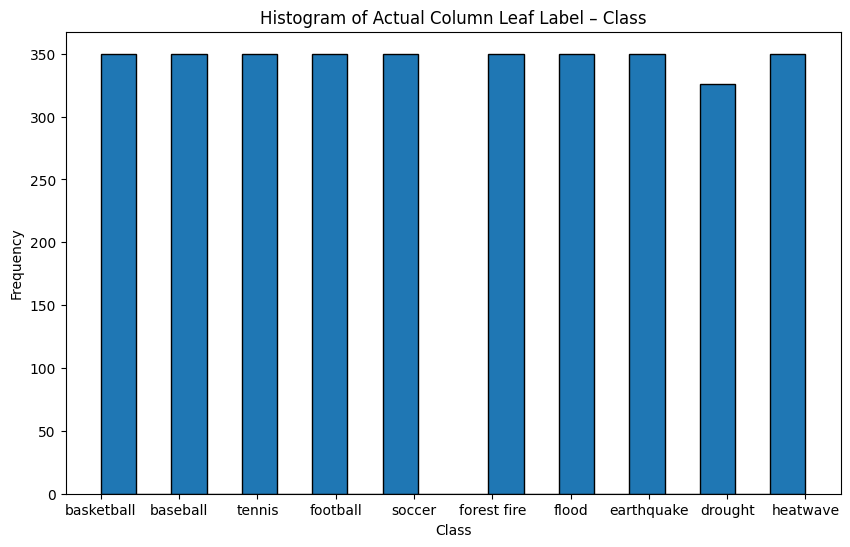

In [3]:
# (b) Histogram for the actual column leaf label – class
leaf_label_column = 'leaf_label'  
plt.figure(figsize=(10, 6))
plt.hist(df[leaf_label_column], bins=20, edgecolor='black')
plt.title('Histogram of Actual Column Leaf Label – Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


#### (c) The column root label – class on the x-axis.

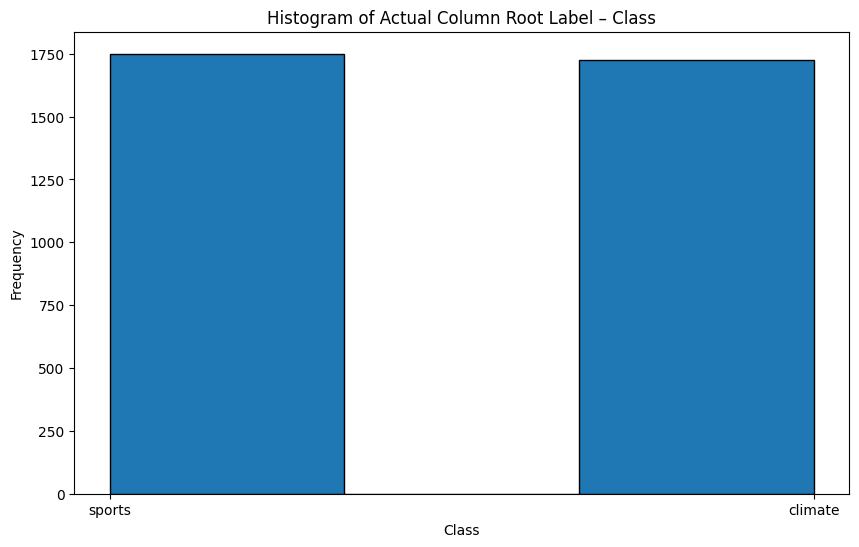

In [4]:
# (c) Histogram for the actual column root label – class
root_label_column = 'root_label'  
plt.figure(figsize=(10, 6))
plt.hist(df[root_label_column], bins=3, edgecolor='black')
plt.title('Histogram of Actual Column Root Label – Class')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

### 1.3 Interpret Plots: Provide qualitative interpretations of the histograms.

** incomplete **

(a) Histogram of Alpha Numeric Characters per Data Point
- Histogram reveals the distribution of the total number of alpha-numeric characters in the 'full_text' feature for each data point

(b) Histogram of Leaf Label Class
- b

(c) Histogram of Root Label Class
- c

## Question 2: Splitting Dataset

In [5]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

### Report the number of training and testing samples.

In [6]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df[["full_text","root_label"]], test_size=0.2)

num_training_samples = len(train)
num_testing_samples = len(test)

print(f"Number of training samples: {num_training_samples}")
print(f"Number of testing samples: {num_testing_samples}")

Number of training samples: 2780
Number of testing samples: 696


## Question 3: Feature Extraction (Lemmatize and Vectorize)


### 3.1 Cleaning each data sample. This function helps remove many but not all HTML artefacts from the crawler’s output. 

In [7]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

Call the clean(text) function to clean the crawler's output and remove most HTML artefacts 

In [8]:
train['full_text'] = train['full_text'].map(clean)
test['full_text'] = test['full_text'].map(clean)

### 3.2 Create the CountVectorizer with "english" stopword

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

count_vect = CountVectorizer(min_df=3, stop_words="english")

### 3.3, 3.4, 3.5 Perform lemmatization with nltk.wordnet.WordNetLemmatizer and pos tag and Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.) using min_df=3

In [10]:
# Lemmatization
import nltk
from nltk import pos_tag

# nltk.download()
wnl = nltk.wordnet.WordNetLemmatizer()

# Penn Trebank to wordnet 
# In the wordnet (ADJ, ADJ_SAT, ADV, NOUN, VERB = 'a', 's', 'r', 'n', 'v', POS_LIST = [NOUN, VERB, ADJ, ADV])
def penn2morphy(penntag):
    """ Converts Penn Treebank tags to WordNet. """
    morphy_tag = {'NN':'n', 'JJ':'a',
                  'VB':'v', 'RB':'r'}
    try:
        return morphy_tag[penntag[:2]]
    except:
        return 'n'

# Lemmatize entire data (data made up of sentences. Lemmatize ever word in every sentence and return the lemmatized data)
def lemmatize(data):
    lemmatized_data = [] 
    for text in data:
        # print("text": text)
        # Return a tokenized copy of text 
        tokens = nltk.word_tokenize(text)
        # print(tokens)
        
        # tags given list of tokens 
        tagged = pos_tag(tokens)
        # print(tagged)

        # lemmatize text excluding numbers 
        lemmatized_words = []
        for word, tag in tagged:
            # print("word: " word)
            if not re.match(r'^\d+(\.\d+)?$', word): # double check this
                lemmatized_word = wnl.lemmatize(word.lower(), pos=penn2morphy(tag))
                lemmatized_words.append(lemmatized_word)
            
        lemmatized_sentence = ' '.join(lemmatized_words)
        
        # Add whole sentence back to the lemmatize_data array 
        lemmatized_data.append(lemmatized_sentence)

    return lemmatized_data

In [11]:
# Lemmatize train and test datasets 
train_lemmatized = lemmatize(train['full_text'])
test_lemmatized = lemmatize(test['full_text'])

In [12]:
# Vectorize the lemmatized train and test datasets 
X_train_counts = count_vect.fit_transform(train_lemmatized)
X_test_counts = count_vect.transform(test_lemmatized)

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
# TF-IDF 
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

print("TD-TFIDF-processed Train Matrix Shape: ", X_train_tfidf.shape)
print("TD-TFIDF-processed Test Matrix Shape: ", X_test_tfidf.shape)

TD-TFIDF-processed Train Matrix Shape:  (2780, 13754)
TD-TFIDF-processed Test Matrix Shape:  (696, 13754)


### 3.6 Answer Questions 

#### (a) What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?
**Lemmatization:** 
It is a technique that involves reducing words to their root form, which is called lemma. 

Pros
1) The base/root words are actual words with meanings. So after lemmatization we do not lose the meaning of a word. 
2) In lemmatization, since we retain the meaning of the words, the accuracy is better than stemming.

Cons
1) It is slower than stemming. 
2) To implement lemmatization we need to have some linguistic understanding. 

**Stemming:** 
Stemming removes suffixes and prefixes from words, so that we can get a common representation called the stem of a word. 

Pros
1) Stemming is less computationally expensive and runs faster. Stemming is easy to implement as it does not take into account the meanings of words.
2)  Stemming helps in reducing the dictionary size. 

Cons
1) The words we obtain after stemming may not be valid words with some meaning. 
2) The acccuracy might be lesser as compared to lemmatization. 

**Dictionary size:**
Stemming gives a smaller dictionary size as it does not consider the meaning of a word, it just reduces the word by removing prefixes or suffixes. Whereas, lemmatization takes into account the meaning and results in a larger dictionary size. 

#### (b) min df means minimum document frequency. How does varying min df change the TF-IDF matrix?
The min_df parameter is used to remove the terms that are very infrequent. If min_df = 3 that means ignore the terms that appear in less than 3 documents. 


#### (c) Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.
- The stopwords are removed after applying the lemmatizer. The punctuations are removed after lemmatizing, and the removing the numbers is also removed after lemmatizing.

#### (d) Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×(10^3). This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.
- The shape of the TD-IDF-processed train matrix is (2780, 13754). The shape of the TD-IDF-processed test matrix is (696, 13754). 

## Question 4: Dimensionality Reduction (LSI and NMF)

#### 4.1.1 Plot the explained variance ratio.

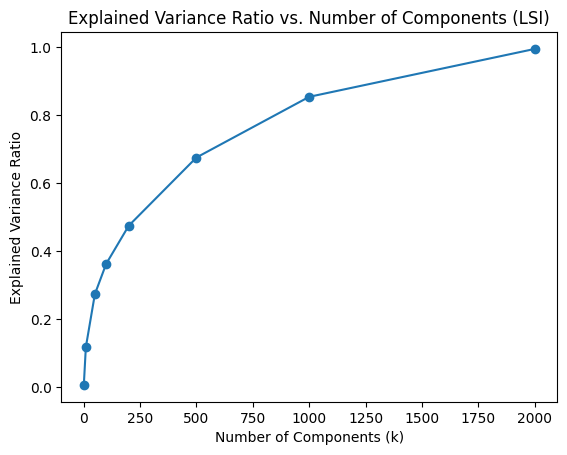

In [14]:
# NOT VALIDATED
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Define values of k
k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]

# Plot explained variance ratio for different values of k
explained_variances = []

for k in k_values:
    lsi = TruncatedSVD(n_components=k, random_state=0)
    lsi.fit_transform(X_train_tfidf)
    explained_variances.append(lsi.explained_variance_ratio_.sum())

plt.plot(k_values, explained_variances, marker='o')
plt.xlabel('Number of Components (k)')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components (LSI)')
plt.show()

#### 4.1.2 What does the explained variance ratio plot look like? 

incomplete

#### 4.1.3 What does the plot’s concavity suggest?
incomplete 

#### 4.2.1 Calculate the reconstruction residual MSE error. 

In [15]:
# LSI
from sklearn.decomposition import TruncatedSVD

lsi = TruncatedSVD(n_components=50, random_state=42)
X_train_lsi = lsi.fit_transform(X_train_tfidf)
X_test_lsi = lsi.transform(X_test_tfidf)

In [16]:
# NMF
from sklearn.decomposition import NMF

nmf = NMF(n_components=50, random_state=42)
X_train_NMF = nmf.fit_transform(X_train_tfidf)
X_test_NMF = nmf.transform(X_test_tfidf)

In [17]:
# LSI Reconstructed Residual MSE Error 
USigmaVt = lsi.inverse_transform(X_train_lsi)
residual_MSE_lsi = np.sum(np.array(X_train_tfidf - USigmaVt)**2)

# NMF Reconstructed Residual MSE Error 
WH = np.dot(X_train_NMF, nmf.components_)
residual_MSE_nmf = np.sum(np.array(X_train_tfidf - WH)**2)

#### 4.2.2 Which one is larger, NMF or LSI and why? 

In [18]:
if residual_MSE_lsi > residual_MSE_nmf: 
    print("LSI has a larger residual MSE error than NMF.")
elif residual_MSE_lsi < residual_MSE_nmf: 
    print("NMF has a larger residual MSE error than LSI.")
else: 
    print("NMF has the same residual MSE error as LSI.")

NMF has a larger residual MSE error than LSI.


incomplete (explain why)

## Question 5: Classification Algorithms (Hard Margin and Soft Margin)

#### 5.1.1 Train one SVM with γ = 1000 (hard margin), another with γ = 0.0001 (soft margin).

In [19]:
from sklearn.svm import SVC

df['label'] = df['root_label'].apply(lambda x: 1 if x == "climate" else 0)
dummy_train, dummy_test = train_test_split(df, test_size=0.2, random_state=42)

# Binary classification labels for training set
Y_train = dummy_train['label'].values

# Binary classification labels for testing set
Y_test = dummy_test['label'].values

In [20]:
# Hard Margin
hard_margin = SVC(C=1000, kernel='linear', random_state=42)

hard_margin = hard_margin.fit(X_train_lsi, Y_train)

Y_test_pred_hard = hard_margin.predict(X_test_lsi)

In [21]:
# Soft Margin
soft_margin = SVC(C=0.0001, kernel='linear', random_state=42)

soft_margin = soft_margin.fit(X_train_lsi, Y_train)

Y_test_pred_soft = soft_margin.predict(X_test_lsi)

#### 5.1.2 Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?

In [22]:
# Generic Code
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc, roc_curve
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

def plot_roc_curve(y_test,decision_function,name=""):
    fpr = dict();tpr = dict();roc_auc = dict()
    fpr, tpr, thresholds = roc_curve(y_test, decision_function)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate');
    plt.title('%s ROC curve' % name);plt.legend(loc="lower right")

def fit_and_predict(cf, X_train, Y_train, X_test): 
    cf = cf.fit(X_train, Y_train)
    Y_pred = cf.predict(X_test)
    return Y_pred

def cf_plot(Y_test, Y_pred, classifier_name): 
    # Confusion Matrix 
    class_names = ['Computer \n Technology', 'Recreational \n Activity']
    cm = confusion_matrix(Y_test, Y_pred) 
    print('Confusion:\n', cm)
    plt.figure(); plot_confusion_matrix(cm, classes=class_names, title=classifier_name + ' Classifier Confusion Matrix')

def statistics(Y_test, Y_pred):
    # Statistics  
    print('Accuracy:', accuracy_score(Y_test, Y_pred))
    print('Recall:', recall_score(Y_test, Y_pred, average='macro'))
    print('Precision:', precision_score(Y_test, Y_pred, average='macro'))
    print('F-1 Score:', f1_score(Y_test, Y_pred, average='macro')) 

In [23]:
# ROC curve
def plot_roc(fpr, tpr, classifier_name=""):
    fig, ax = plt.subplots()

    roc_auc = auc(fpr,tpr)

    ax.plot(fpr, tpr, lw=2, label= 'area under curve = %0.4f' % roc_auc)

    ax.grid(color='0.7', linestyle='--', linewidth=1)

    ax.set_xlim([-0.1, 1.1])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=15)
    ax.set_ylabel('True Positive Rate',fontsize=15)

    ax.legend(loc="lower right")
    ax.set_title(classifier_name + " ROC Curve", fontsize=16)

    for label in ax.get_xticklabels()+ax.get_yticklabels():
        label.set_fontsize(15)

def fit_predict_and_plot_roc(pipe, train_data, train_label, test_data, test_label, classifier_name=""):
    pipe.fit(train_data, train_label)
    # pipeline1.predict(twenty_test.data)

    if hasattr(pipe, 'decision_function'):
        prob_score = pipe.decision_function(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score)
    else:
        prob_score = pipe.predict_proba(test_data)
        fpr, tpr, _ = roc_curve(test_label, prob_score[:,1])

    plot_roc(fpr, tpr, classifier_name)

In [ ]:
def report(cf, X_train, X_test, Y_train, Y_test, classifier_name): 
    Y_pred = fit_and_predict(cf, X_train, Y_train, X_test)
    fit_predict_and_plot_roc(cf, X_train, Y_train, X_test, Y_test, classifier_name) # added
    cf_plot(Y_test, Y_pred, classifier_name)
    statistics(Y_test, Y_pred)

Hard Margin


Confusion Matrix:
 [[351  17]
 [  9 319]]
Accuracy: 0.9626436781609196
Recall: 0.9725609756097561
Precision: 0.9494047619047619
F-1 Score: 0.9608433734939759


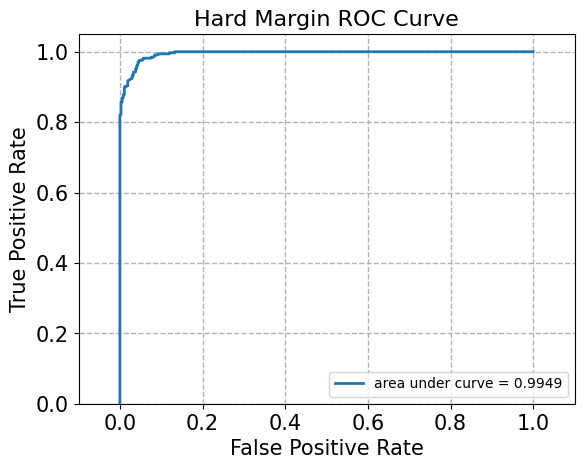

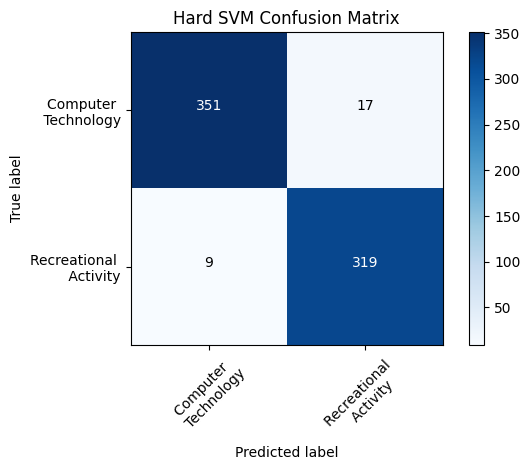

In [24]:
# Hard Margin 
print("Hard Margin")

hard_m = SVC(C=1000, kernel='linear', random_state=42)
# report(hard_m, X_train_lsi, X_test_lsi, Y_train, Y_test, "Hard Margin") # added

# ROC Curve 
fit_predict_and_plot_roc(hard_m, X_train_lsi, Y_train, X_test_lsi, Y_test, "Hard Margin ROC Curve")

# Confusion Matrix 
print('Confusion Matrix:\n', confusion_matrix(Y_test, Y_test_pred_hard))
class_names = ['Computer \n Technology', 'Recreational \n Activity']
hard_cm = confusion_matrix(Y_test, Y_test_pred_hard) 
plt.figure(); plot_confusion_matrix(hard_cm, classes=class_names, title='Hard SVM Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_hard))
print('Recall:', recall_score(Y_test, Y_test_pred_hard))
print('Precision:', precision_score(Y_test, Y_test_pred_hard))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_hard))

# γ = 100000
hard_margin = SVC(C=100000, kernel='linear', random_state=42)

hard_margin = hard_margin.fit(X_train_lsi, Y_train)

Y_test_pred_hard = hard_margin.predict(X_test_lsi)

Soft Margin


Confusion:
 [[  0 368]
 [  0 328]]
Accuracy: 0.47126436781609193
Recall: 1.0
Precision: 0.47126436781609193
F-1 Score: 0.640625


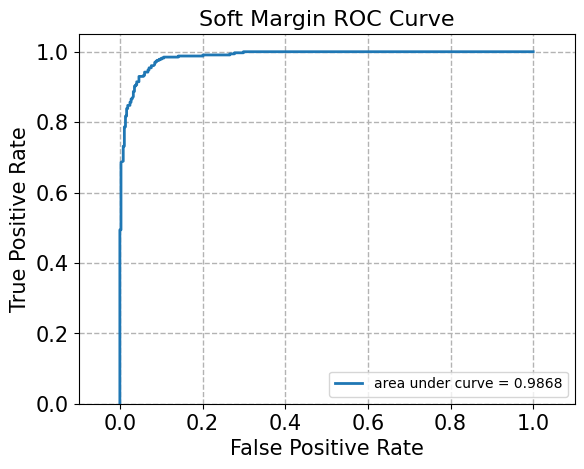

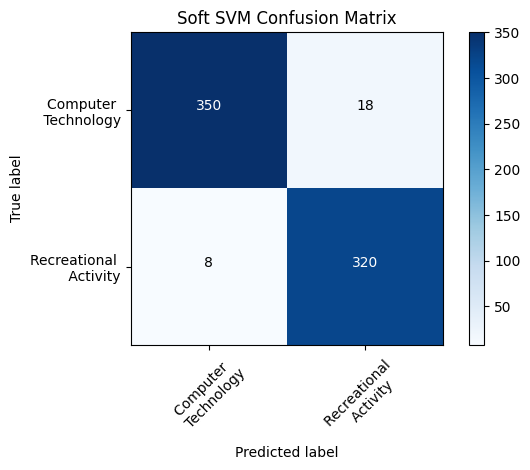

In [25]:
# Soft Margin 
print("Soft Margin")

soft_m = SVC(C=0.0001, kernel='linear', random_state=42)
# report(soft_m, X_train_lsi, X_test_lsi, Y_train, Y_test, "Soft Margin") # added

# ROC Curve 
fit_predict_and_plot_roc(soft_m, X_train_lsi, Y_train, X_test_lsi, Y_test, "Soft Margin ROC Curve")

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(Y_test, Y_test_pred_soft))
class_names = ['Computer \n Technology', 'Recreational \n Activity']
soft_cm = confusion_matrix(Y_test, Y_test_pred_hard) 
plt.figure(); plot_confusion_matrix(soft_cm, classes=class_names, title='Soft SVM Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_soft))
print('Recall:', recall_score(Y_test, Y_test_pred_soft))
print('Precision:', precision_score(Y_test, Y_test_pred_soft))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_soft))

# γ = 100000
svm_soft = SVC(C=100000, kernel='linear', random_state=42)

svm_soft = svm_soft.fit(X_train_lsi, Y_train)

Y_test_pred_soft = svm_soft.predict(X_test_lsi)

#### 5.1.3 What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.

incomplete

#### 5.1.4 Does the ROC curve reflect the performance of the soft-margin SVM? Why?

incomplete

#### 5.2.1 Use cross-validation to choose γ (use average validation 3 accuracy to compare): Using a 5-fold cross-validation, find the best value of the parameter γ in the range {10k| − 3 ≤ k ≤ 6, k ∈ Z}. 

In [26]:
from sklearn.model_selection import cross_val_score

# Cross Validation
gamma_vals = [10**k for k in range(-3, 7)]

best_gamma = None
best_accuracy = 0

# Iterate through gamma values 
for gamma in gamma_vals:
    svc = SVC(kernel='linear', C=gamma).fit(X_train_lsi, Y_train)
    scores = cross_val_score(svc, X_train_lsi, Y_train,cv=5, scoring='accuracy')

    # Set the best gamma if it is a higher mean score  
    if (np.mean(scores) > best_accuracy):
        best_gamma = gamma
        best_accuracy = np.mean(scores)

print(best_gamma)

100


#### 5.2.2 Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.

Cross Validation
Confusion:
 [[353  15]
 [ 13 315]]
Accuracy: 0.9597701149425287
Recall: 0.9603658536585366
Precision: 0.9545454545454546
F-1 Score: 0.9574468085106383
F-1 Score: 0.9574468085106383


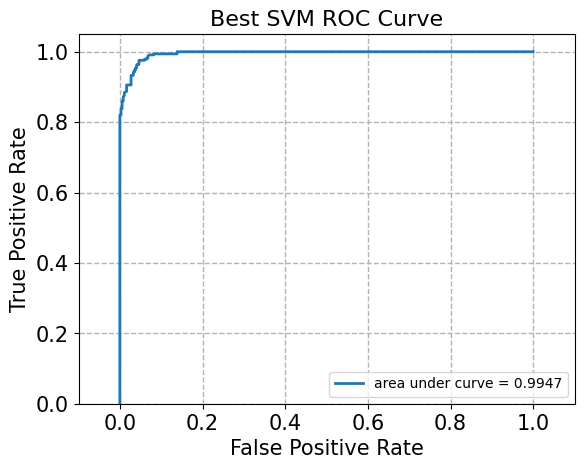

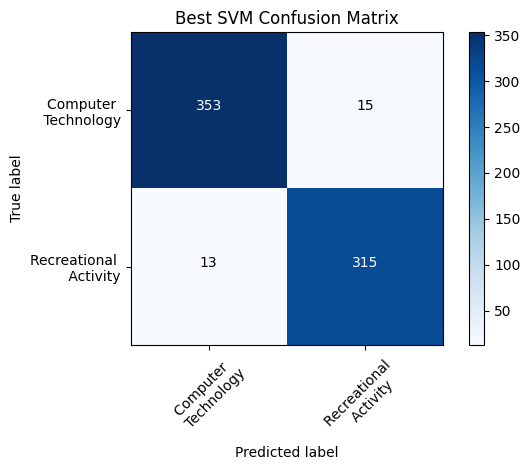

In [27]:
# Setup SVM for best SVM 
print("Cross Validation")
best_svm = SVC(kernel='linear', C=best_gamma)
# report(soft_m, X_train_lsi, X_test_lsi, Y_train, Y_test, "Best SVM") # added

best_svm = best_svm.fit(X_train_lsi, Y_train)
Y_test_pred_best = best_svm.predict(X_test_lsi)

# ROC Curve 
fit_predict_and_plot_roc(best_svm, X_train_lsi, Y_train, X_test_lsi, Y_test, "Best SVM ROC Curve")

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(Y_test, Y_test_pred_best))
best_cm = confusion_matrix(Y_test, Y_test_pred_best) 
plt.figure(); plot_confusion_matrix(best_cm, classes=class_names, title='Best SVM Confusion Matrix')

# Statistics 
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_best))
print('Recall:', recall_score(Y_test, Y_test_pred_best))
print('Precision:', precision_score(Y_test, Y_test_pred_best))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_best))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_best))

## Question 6: Logistic Classifier

#### 6.1.1 Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression)

In [28]:
from sklearn.linear_model import LogisticRegression

# Train logistic regression classifier without regularization
lr_wo_reg = LogisticRegression(C=10**10, solver='liblinear', random_state=42)
# report(lr_wo_reg, X_train_lsi, X_test_lsi, Y_train, Y_test, "Logistic Regression Without Regularization") # added
lr_wo_reg = lr_wo_reg.fit(X_train_lsi, Y_train)
Y_test_pred_lr = lr_wo_reg.predict(X_test_lsi)

#### 6.1.2 Plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1score of this classifier on the testing set.

Cross Validation
Confusion:
 [[352  16]
 [ 13 315]]
Accuracy: 0.9583333333333334
Recall: 0.9603658536585366
Precision: 0.9516616314199395
F-1 Score: 0.9559939301972686


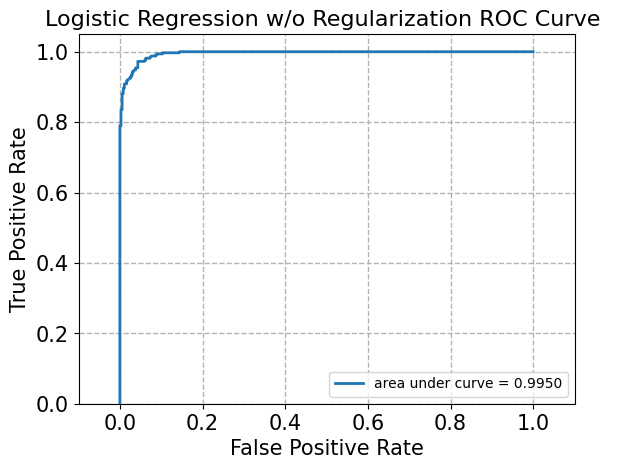

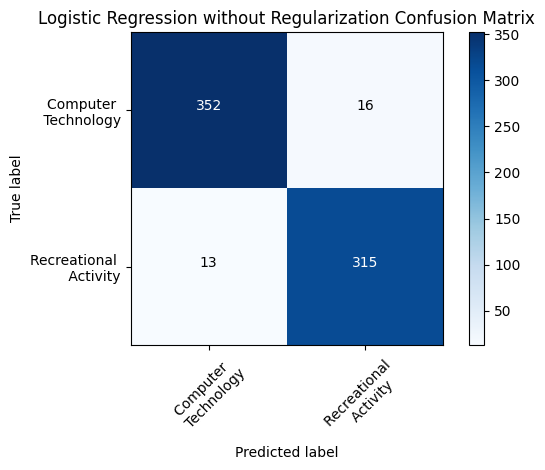

In [29]:
print("Cross Validation")

# ROC Curve 
fit_predict_and_plot_roc(lr_wo_reg, X_train_lsi, Y_train, X_test_lsi, Y_test, "Logistic Regression w/o Regularization ROC Curve ")

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(Y_test, Y_test_pred_lr))
lr_wo_reg_cm = confusion_matrix(Y_test, Y_test_pred_lr) 
plt.figure(); plot_confusion_matrix(lr_wo_reg_cm, classes=class_names, title='Logistic Regression without Regularization Confusion Matrix')

# Statistics 
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_lr))
print('Recall:', recall_score(Y_test, Y_test_pred_lr))
print('Precision:', precision_score(Y_test, Y_test_pred_lr))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_lr))

### 6.2 Find the optimal regularization coefficient

#### 6.2.1 Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the optimal regularization strength in the range {10k|−5 ≤ k ≤ 5, k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.

In [30]:
# Finding optimal regularization strength

def opt_reg_strength(X_train, Y_train, penalty):
    reg_strength = [10**k for k in range(-5, 6)]

    best_strength = None
    best_score = 0

    # Creates a Logistic Regression for each strength level 
    for strength in reg_strength:
        lr = LogisticRegression(C=strength, penalty=penalty, solver='liblinear', random_state=42).fit(X_train, Y_train)
        scores = cross_val_score(lr, X_train, Y_train,cv=5, scoring='accuracy')

        # updates best strength given if higher mean score 
        if (np.mean(scores) > best_score):
            best_strength = strength
            best_score = np.mean(scores)

    return best_strength

In [31]:
opt_strength_lr_l1 = opt_reg_strength(X_train_lsi, Y_train, 'l1')
opt_strength_lr_l2 = opt_reg_strength(X_train_lsi, Y_train, 'l2')

print("Optimal Regularization Strength for L1: ", opt_strength_lr_l1)
print("Optimal Regularization Strength for L2: ", opt_strength_lr_l2)

Optimal Regularization Strength for L1:  10
Optimal Regularization Strength for L2:  100


#### 6.2.2 Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classifiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.

In [32]:
# Performance of Logistic Classifier w/o regularization
lr_wo_reg = LogisticRegression(C=10**10, solver='liblinear', random_state=42)
# report(lr_wo_reg, X_train_lsi, X_test_lsi, Y_train, Y_test, "Logistic Regression Without Regularization") # added
lr_wo_reg = lr_wo_reg.fit(X_train_lsi, Y_train)
Y_test_pred_lr = lr_wo_reg.predict(X_test_lsi)

# Statistics 
print("-"*20 + " Performance of Logistic Classifier w/o regularization "+ "-"*20)
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_lr))
print('Recall:', recall_score(Y_test, Y_test_pred_lr))
print('Precision:', precision_score(Y_test, Y_test_pred_lr))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_lr))

# Performance of Logistic Classifier w/ L1 regularization
lr_w_l1 = LogisticRegression(C=opt_strength_lr_l1, solver='liblinear', penalty='l1', random_state=42)
# report(lr_w_l1, X_train_lsi, X_test_lsi, Y_train, Y_test, "Logistic Regression With L1 Regularization") # added
lr_w_l1 = lr_w_l1.fit(X_train_lsi, Y_train)
Y_test_pred_lr_l1 = lr_w_l1.predict(X_test_lsi)

# Statistics 
print("-"*20 + " Performance of Logistic Classifier w/ L1 regularization "+ "-"*20)
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_lr_l1))
print('Recall:', recall_score(Y_test, Y_test_pred_lr_l1))
print('Precision:', precision_score(Y_test, Y_test_pred_lr_l1))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_lr_l1))

# Performance of Logistic Classifier w/ L2 regularization
lr_w_l2 = LogisticRegression(C=opt_strength_lr_l2, solver='liblinear', penalty='l2', random_state=42)
# report(lr_w_l2, X_train_lsi, X_test_lsi, Y_train, Y_test, "Logistic Regression With L2 Regularization") # added
lr_w_l2 = lr_w_l2.fit(X_train_lsi, Y_train)
Y_test_pred_lr_l2 = lr_w_l2.predict(X_test_lsi)

# Statistics 
print("-"*20 + " Performance of Logistic Classifier w/ L2 regularization "+ "-"*20)
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_lr_l2))
print('Recall:', recall_score(Y_test, Y_test_pred_lr_l2))
print('Precision:', precision_score(Y_test, Y_test_pred_lr_l2))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_lr_l2))

-------------------- Performance of Logistic Classifier w/o regularization --------------------
Accuracy: 0.9583333333333334
Recall: 0.9603658536585366
Precision: 0.9516616314199395
F-1 Score: 0.9559939301972686
-------------------- Performance of Logistic Classifier w/ L1 regularization --------------------
Accuracy: 0.9597701149425287
Recall: 0.9634146341463414
Precision: 0.9518072289156626
F-1 Score: 0.9575757575757575
-------------------- Performance of Logistic Classifier w/ L2 regularization --------------------
Accuracy: 0.9597701149425287
Recall: 0.9603658536585366
Precision: 0.9545454545454546
F-1 Score: 0.9574468085106383


#### 6.2.3 How does the regularization parameter affect the test error? How are the learnt coefficients affected? Why might one be interested in each type of regularization?

incomplete (explain why)

#### 6.2.4 Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?

## Question 7: Naive Bayes Classifier

### 7.1.1 Evaluate and profile a Naive Bayes classifier: Train a GaussianNB classifier

In [33]:
from sklearn.naive_bayes import GaussianNB

# Train Gaussian Naive Bayes classifier 
gnb_cf = GaussianNB()
# report(gnb_cf, X_train_lsi, X_test_lsi, Y_train, Y_test, "Gaussian Naive Bayes") # added
gnb_cf = gnb_cf.fit(X_train_lsi, Y_train)
Y_test_pred_gnb = gnb_cf.predict(X_test_lsi)

### 7.1.2 Plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.

Naive Bayes Classifier
Confusion:
 [[358  10]
 [ 61 267]]
Accuracy: 0.8979885057471264
Recall: 0.8140243902439024
Precision: 0.9638989169675091
F-1 Score: 0.8826446280991735


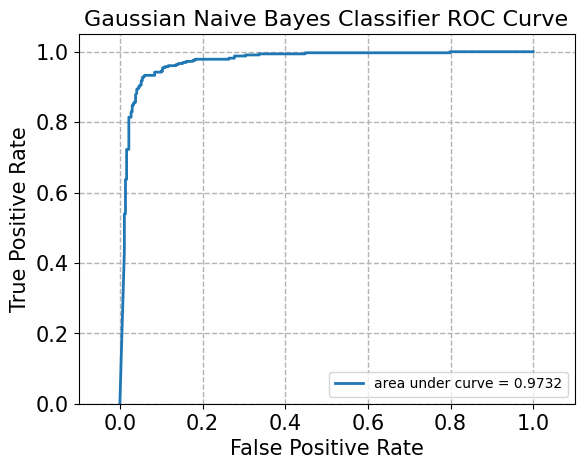

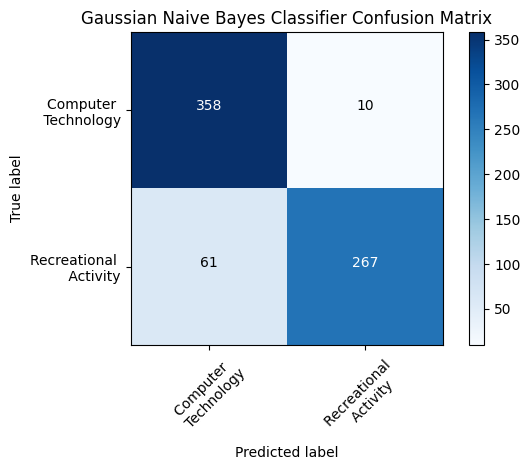

In [34]:
print("Naive Bayes Classifier")

# ROC Curve 
fit_predict_and_plot_roc(gnb_cf, X_train_lsi, Y_train, X_test_lsi, Y_test, "Gaussian Naive Bayes Classifier ROC Curve")

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(Y_test, Y_test_pred_gnb))
gnb_cm = confusion_matrix(Y_test, Y_test_pred_gnb) 
plt.figure(); plot_confusion_matrix(gnb_cm, classes=class_names, title='Gaussian Naive Bayes Classifier Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(Y_test, Y_test_pred_gnb))
print('Recall:', recall_score(Y_test, Y_test_pred_gnb))
print('Precision:', precision_score(Y_test, Y_test_pred_gnb))
print('F-1 Score:', f1_score(Y_test, Y_test_pred_gnb))

## Question 8: Binary Classification (Pipeline)

### 8.1 Construct a Pipeline that performs feature extraction, dimensionality reduction and classification

In [35]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words='english')), # vectorize (feature extraction)
    ('tfidf', TfidfTransformer()), # transformer
    ('reduce_dim', TruncatedSVD()), # dimensionality reduction
    ('clf', SVC()), # classification
])

### 8.2 The evaluation of each combination is performed with 5-fold cross-validation (use the average validation set accuracy across folds).

#### 8.2.1 In addition to any other hyperparameters you choose, your gridsearch must at least include: Loading Data, Feature Extraction, Dimensionality Reduction, Classifier, Other options. 

In [36]:
# check loading data section !!!!!!!!!
from nltk.stem import PorterStemmer

# hyperparameters = [
#     {
#         'vect__min_df': [3,5], # Feature Extraction: min_df (3 vs 5),
#         'reduce_dim': [# Dimensionality Reduction: LSI vs NMF (k = [5, 30, 80])
#             TruncatedSVD(n_components=5, random_state=42),
#             TruncatedSVD(n_components=30, random_state=42),
#             TruncatedSVD(n_components=80, random_state=42),
#             NMF(n_components=5, random_state=42, max_iter=2000),
#             NMF(n_components=30, random_state=42, max_iter=2000),
#             NMF(n_components=80, random_state=42, max_iterm=2000)
#         ], 
#         'clf': [ # Classifier: SVM (best gamma), L1 Regularization, L2 Regularization, GaussianNB
#             SVC(C=best_gamma, kernel='linear'), 
#             LogisticRegression(C=opt_strength_lr_l1, penalty = 'l1', solver='liblinear', random_state=42),
#             LogisticRegression(C=opt_strength_lr_l2, penalty = 'l2', random_state=42),
#             GaussianNB(),
#         ]
#     }
# ]

# For testing purposes 
hyperparameters = [
    {
        'vect__min_df': [3,5], # Feature Extraction: min_df (3 vs 5)
        'reduce_dim': [# Dimensionality Reduction: LSI vs NMF (k = [5, 30, 80])
            TruncatedSVD(n_components=5, random_state=42),
        ], 
        'clf': [ # Classifier: SVM (best gamma), L1 Regularization, L2 Regularization, GaussianNB
            SVC(C=best_gamma, kernel='linear'), 
        ]
    }
]

In [47]:
from sklearn.model_selection import GridSearchCV

# Create Grid 

grid_lemmatized = GridSearchCV(
    pipeline, 
    cv=5, 
    n_jobs=-1, 
    param_grid=hyperparameters, 
    scoring='accuracy'
)

grid_stemmed = GridSearchCV(
    pipeline, 
    cv=5, 
    n_jobs=-1, 
    param_grid=hyperparameters, 
    scoring='accuracy'
)

In [50]:
# Lemmatized Fit and Predict 
grid_lemmatized = grid_lemmatized.fit(train_lemmatized, Y_train)
grid_lemmatized_pred = grid_lemmatized.predict(test_lemmatized)

In [51]:
# Stem
import nltk
from nltk.stem import PorterStemmer
import re

# nltk.download()

# Stem entire data 
def stem(data):
    stemmed_data = [] 
    for text in data:
        # print("text": text)
        # Return a tokenized copy of text 
        tokens = nltk.word_tokenize(text)
        # print(tokens)
        
        # tags given list of tokens 
        tagged = pos_tag(tokens)
        # print(tagged)

        # lemmatize text excluding numbers 
        stemmed_words = []
        for word in tokens:
            # print("word: " word)
            if not re.match(r'^\d+(\.\d+)?$', word): # double check this
                stemmed_word = PorterStemmer().stem(word.lower())
                stemmed_words.append(stemmed_word)
            
        stemmed_sentence = ' '.join(stemmed_words)
        
        # Add whole sentence back to the lemmatize_data array 
        stemmed_data.append(stemmed_sentence)

    return stemmed_data

In [45]:
# Stemmed data 
train_stemmed = stem(train['full_text'])
test_stemmed = stem(test['full_text'])

In [48]:
# Stemmed Fit and Predict 
grid_stemmed = grid_stemmed.fit(train_stemmed, Y_train)
grid_stemmed_pred = grid_stemmed.predict(test_stemmed)

### 8.3 What are the 5 best combinations? Report their performances on the testing set.

In [52]:
# Best Model and Best Parameters 
# grid_model_best_lemmatized = grid_lemmatized.best_estimator_
# grid_params_best_lemmatized = grid_lemmatized.best_params_
grid_lemmatized_result = pd.DataFrame(grid_lemmatized.cv_results_)

# grid_model_best_stemmed = grid_stemmed.best_estimator_
# grid_params_best_stemmed = grid_stemmed.best_params_
grid_stemmed_result = pd.DataFrame(grid_stemmed.cv_results_)

In [55]:
# Display Best Results 
grid_lemmatized_result['lemmatized'] = True
grid_stemmed_result['lemmatized'] = False
results = pd.concat([grid_lemmatized_result, grid_lemmatized_result])
results = results[['mean_test_score', 'param_clf', 'param_reduce_dim','param_vect__min_df', 'lemmatized']].sort_values(by=['mean_test_score'], ascending=False)
results = results.reset_index(drop=True)
pd.set_option('display.max_colwidth', None)
results.head()

,mean_test_score,param_clf,param_reduce_dim,param_vect__min_df,lemmatized
0,0.929496,"SVC(C=100, kernel='linear')","TruncatedSVD(n_components=5, random_state=42)",5,True
1,0.929496,"SVC(C=100, kernel='linear')","TruncatedSVD(n_components=5, random_state=42)",5,True
2,0.928058,"SVC(C=100, kernel='linear')","TruncatedSVD(n_components=5, random_state=42)",3,True
3,0.928058,"SVC(C=100, kernel='linear')","TruncatedSVD(n_components=5, random_state=42)",3,True


## Question 9

### 9.1.1 Perform Naive Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above). 

In [56]:
# Multiclass Train and Test 
mc_train, mc_test = train_test_split(df[["full_text","leaf_label"]], test_size=0.2)

mc_train['full_text'] = mc_train['full_text'].map(clean)
mc_test['full_text'] = mc_test['full_text'].map(clean)

In [57]:
# Setting Mapping 

map_row_to_class = {0:"basketball", 1:"baseball", 2:"tennis",
3:"football", 4:"soccer", 5:"forest fire", 6:"flood",
7:"earthquake", 8:"drought", 9:"heatwave"}

reverse_row_to_class = {
    v: k for k, v in map_row_to_class.items()
}

In [58]:
# Lemmatization
mc_train_lemmatized = lemmatize(mc_train['full_text'])
mc_test_lemmatized = lemmatize(mc_test['full_text'])

In [59]:
# Count Vectorizer
mc_count_vect = CountVectorizer(min_df=3, stop_words="english")
mc_X_train_counts = mc_count_vect.fit_transform(mc_train_lemmatized).toarray()
mc_X_test_counts = mc_count_vect.transform(mc_test_lemmatized).toarray()

In [60]:
# TFIDF
mc_tfidf_transformer = TfidfTransformer()
mc_X_train_tfidf = mc_tfidf_transformer.fit_transform(mc_X_train_counts).toarray()
mc_X_test_tfidf = mc_tfidf_transformer.transform(mc_X_test_counts).toarray()

In [61]:
# LSI
mc_lsi = TruncatedSVD(n_components=50, random_state=42)
mc_X_train_lsi = mc_lsi.fit_transform(mc_X_train_tfidf)
mc_X_test_lsi = mc_lsi.transform(mc_X_test_tfidf)

In [62]:
# NMF
mc_nmf = NMF(n_components=50, max_iter=2000, random_state=42)
mc_X_train_NMF = mc_nmf.fit_transform(mc_X_train_tfidf)
mc_X_test_NMF = mc_nmf.transform(mc_X_test_tfidf)

In [63]:
# Setting up Y train and test based on mapping 
mc_train['mc_label'] = mc_train['leaf_label'].apply(lambda x: reverse_row_to_class[x] if x in reverse_row_to_class else 'dumb')
mc_test['mc_label'] = mc_test['leaf_label'].apply(lambda x: reverse_row_to_class[x] if x in reverse_row_to_class else 'dumb')
mc_Y_train = mc_train['mc_label']
mc_Y_test = mc_test['mc_label']

### 9.1.2 Report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers. 

Make report generic 

In [76]:
# def fit_and_predict(cf, X_train, Y_train, X_test): 
#     cf = cf.fit(X_train, Y_train)
#     Y_pred = cf.predict(X_test)
#     return Y_pred

# def cf_plot(Y_test, Y_pred, classifier_name): 
#     # Confusion Matrix 
#     cm = confusion_matrix(Y_test, Y_pred) 
#     print('Confusion:\n', cm)
#     plt.figure(); plot_confusion_matrix(cm, classes=map_row_to_class, title=classifier_name + ' Classifier Confusion Matrix')

# def statistics(Y_test, Y_pred):
#     # Statistics  
#     print('Accuracy:', accuracy_score(Y_test, Y_pred))
#     print('Recall:', recall_score(Y_test, Y_pred, average='macro'))
#     print('Precision:', precision_score(Y_test, Y_pred, average='macro'))
#     print('F-1 Score:', f1_score(Y_test, Y_pred, average='macro')) 

In [84]:
def multiclass_report(cf, X_train, X_test, Y_train, Y_test, classifier_name): 
    Y_pred = fit_and_predict(cf, X_train, Y_train, X_test)
    cf_plot(Y_test, Y_pred, classifier_name)
    statistics(Y_test, Y_pred)

In [85]:
# Loop through Count Vectorizor, TFIDF, LSI, and NMF 
mc_classifiers = {
    "Count Vectorizor": [mc_X_train_counts, mc_X_test_counts], 
    "TF-IDF": [mc_X_train_tfidf, mc_X_test_tfidf], 
    "LSI": [mc_X_train_lsi, mc_X_test_lsi], 
    "NMF": [mc_X_train_NMF, mc_X_test_NMF], 
}

Linear SVC 

Count Vectorizor
Confusion:
 [[53  0  0  1  0  0  0  0  0  0]
 [ 1 54  1  2  1  1  0  1  0  3]
 [ 1  5 53  3  0  2  1  0  0  2]
 [ 0  3  0 57  2  1  0  0  1  1]
 [ 3  3  0  2 71  0  0  0  0  3]
 [ 0  1  1  0  0  6  0  0  1 68]
 [ 0  4  0  0  0  2 63  0  1  2]
 [ 1  2  1  0  0  1  0 75  2  1]
 [ 0  2  1  0  0  2  2  0 51  3]
 [ 1  1  0  0  1 60  0  0  1  7]]
Accuracy: 0.7040229885057471
Recall: 0.7150246651880218
Precision: 0.7350649818018238
F-1 Score: 0.7229773738493471
TF-IDF
Confusion:
 [[54  0  0  0  0  0  0  0  0  0]
 [ 0 58  3  1  0  0  0  0  0  2]
 [ 0  2 62  0  0  1  1  0  0  1]
 [ 0  3  2 57  1  2  0  0  0  0]
 [ 0  2  1  2 75  1  0  0  0  1]
 [ 0  0  1  0  0  7  0  0  1 68]
 [ 0  1  0  0  0  4 65  0  1  1]
 [ 0  1  1  0  0  1  0 79  0  1]
 [ 0  1  0  0  0  4  0  0 55  1]
 [ 0  1  0  0  1 61  0  0  0  8]]
Accuracy: 0.7471264367816092
Recall: 0.7582989855795753
Precision: 0.7782886030690521
F-1 Score: 0.7674730882739886
LSI
Confusion:
 [[52  0  0  0  1  0  0  1  0  0]
 [ 0 56  

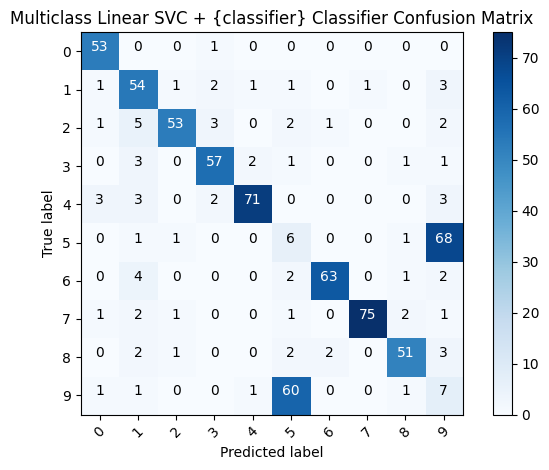

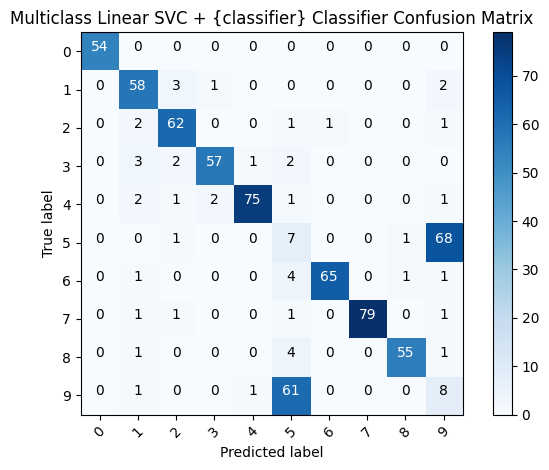

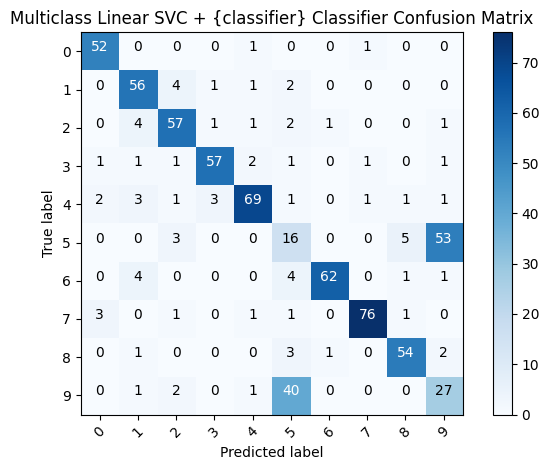

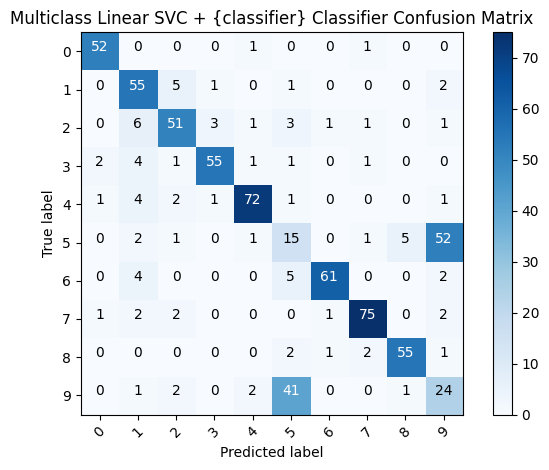

In [81]:
# Linear SVC 
mc_cf = SVC(C=100000, kernel='linear', random_state=42)
for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass Linear SVC + " + classifier)

Naive Bayes

Count Vectorizor


Confusion:
 [[48  1  3  2  0  0  0  0  0  0]
 [ 2 45  6  1  0  2  1  0  0  7]
 [ 1  5 45  2  3  4  1  2  0  4]
 [ 6  6  5 41  4  2  1  0  0  0]
 [ 4  3  8  4 56  2  0  0  2  3]
 [ 1  0  0  2  0  3  1  1  2 67]
 [ 0  2  1  0  0  6 51  1  6  5]
 [ 0  3  3  0  1  3  0 65  4  4]
 [ 0  1  0  0  0  8  1  1 39 11]
 [ 0  0  0  0  1 54  3  0  2 11]]
Accuracy: 0.5804597701149425
Recall: 0.5902052482145914
Precision: 0.6375812235858613
F-1 Score: 0.6093025884903799
TF-IDF
Confusion:
 [[47  2  4  1  0  0  0  0  0  0]
 [ 0 43  9  2  0  3  1  0  0  6]
 [ 1  4 43  2  5  5  1  2  1  3]
 [ 4  7  4 41  5  2  1  0  0  1]
 [ 4  3  8  3 54  3  0  0  3  4]
 [ 0  0  0  2  1  5  1  0  1 67]
 [ 0  2  1  0  0  7 51  0  6  5]
 [ 0  2  3  0  2  3  0 66  3  4]
 [ 0  0  0  0  0  9  1  1 39 11]
 [ 0  0  0  0  1 56  3  0  1 10]]
Accuracy: 0.5732758620689655
Recall: 0.5821980685159156
Precision: 0.6404091106697872
F-1 Score: 0.6071333912268668
LSI
Confusion:
 [[47  3  1  3  0  0  0  0  0  0]
 [ 0 57  2  1  1  1  2  0 

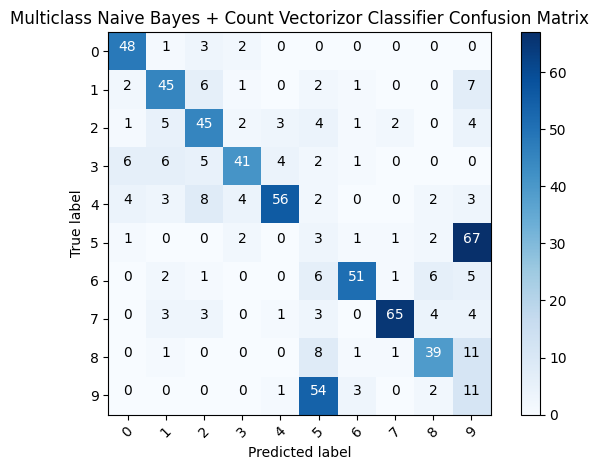

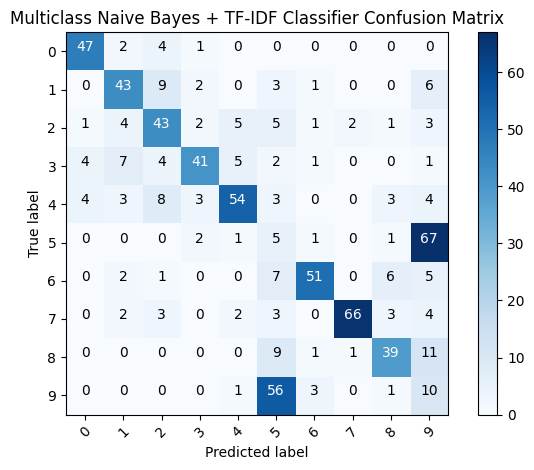

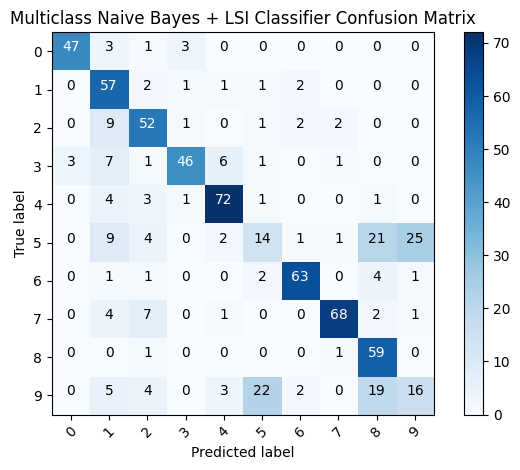

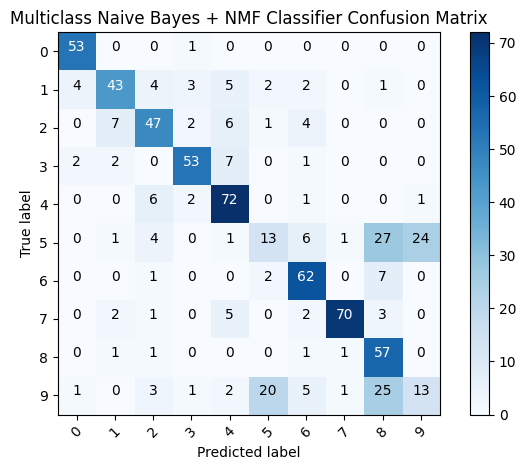

In [80]:
# Naive Bayes 
mc_cf = GaussianNB()
for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass Naive Bayes + " + classifier)

One VS One

Count Vectorizor---------------------------
Confusion:
 [[53  0  0  1  0  0  0  0  0  0]
 [ 1 53  1  2  1  1  0  1  0  4]
 [ 1  5 52  3  0  3  1  0  0  2]
 [ 0  3  0 57  2  1  0  0  1  1]
 [ 3  3  0  2 71  0  0  0  0  3]
 [ 0  1  1  0  0  6  0  0  1 68]
 [ 0  3  0  0  0  2 63  0  1  3]
 [ 1  2  1  0  0  1  0 74  2  2]
 [ 0  1  1  0  0  3  2  0 51  3]
 [ 1  1  0  0  1 60  0  0  1  7]]
Accuracy: 0.6997126436781609
Recall: 0.7107648085974805
Precision: 0.736074547504938
F-1 Score: 0.721359350730513


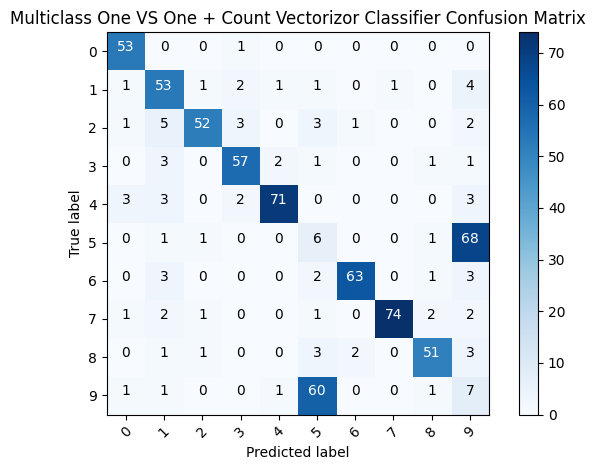

In [86]:
# One VS One 
from sklearn.multiclass import OneVsOneClassifier

mc_cf = OneVsOneClassifier(SVC(kernel='linear', random_state=42))

for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass One VS One + " + classifier)

One VS Rest 

In [ ]:
# One VS Rest 
from sklearn.multiclass import OneVsRestClassifier

mc_cf = OneVsRestClassifier(SVC(kernel='linear', random_state=42))

for classifier, (X_train, X_test) in mc_classifiers.items():
    print(classifier + '---------------------------')
    multiclass_report(mc_cf, X_train, X_test, mc_Y_train, mc_Y_test, "Multiclass One VS Rest + " + classifier)

One VS One Classifier

In [ ]:

# One VS One + Count Vectorizor  
from sklearn.multiclass import OneVsOneClassifier

mc_1v1 = OneVsOneClassifier(SVC(kernel='linear', random_state=42))
mc_1v1.fit(mc_X_train_counts, mc_Y_train)
mc_Y_test_pred_1v1 = mc_1v1.predict(mc_X_test_counts)

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(mc_Y_test, mc_Y_test_pred_1v1))
mc_gnb_cm = confusion_matrix(mc_Y_test, mc_Y_test_pred_1v1) 
plt.figure(); plot_confusion_matrix(mc_1v1, classes=map_row_to_class, title='Multiclass One VS One + Count Vectorizor Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(mc_Y_test, mc_Y_test_pred_1v1))
print('Recall:', recall_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro'))
print('Precision:', precision_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro'))
print('F-1 Score:', f1_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro')) 

Confusion:
 [[84  0  1  0  0  0  0  0  2  0]
 [ 0 53  1  0  0  0  2  0  0  1]
 [ 0  0 14  0  0  0  0  1  0 50]
 [ 0  0  2 71  0  0  0  0  0  0]
 [ 0  0  1  1 71  0  0  0  0  1]
 [ 0  0  6  1  0 63  1  0  0  1]
 [ 0  0  1  0  0  0 63  1  0  2]
 [ 0  0  2  0  0  0  3 64  0  0]
 [ 1  1  0  0  0  0  0  0 61  0]
 [ 0  0 58  0  0  3  0  1  0  7]]


TypeError: Image data of dtype object cannot be converted to float

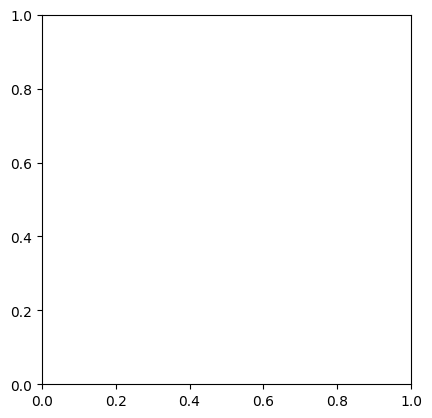

In [136]:
# One VS One + TFIDF 
from sklearn.multiclass import OneVsOneClassifier

mc_1v1 = OneVsOneClassifier(SVC(kernel='linear', random_state=42))
mc_1v1.fit(mc_X_train_tfidf, mc_Y_train)
mc_Y_test_pred_1v1 = mc_1v1.predict(mc_X_test_tfidf)

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(mc_Y_test, mc_Y_test_pred_1v1))
mc_gnb_cm = confusion_matrix(mc_Y_test, mc_Y_test_pred_1v1) 
plt.figure(); plot_confusion_matrix(mc_1v1, classes=map_row_to_class, title='Multiclass One VS One + TFIDF Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(mc_Y_test, mc_Y_test_pred_1v1))
print('Recall:', recall_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro'))
print('Precision:', precision_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro'))
print('F-1 Score:', f1_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro')) 

In [ ]:
# One VS One + LSI
mc_1v1 = OneVsOneClassifier(SVC(kernel='linear', random_state=42))
mc_1v1.fit(mc_X_train_lsi, mc_Y_train)
mc_Y_test_pred_1v1 = mc_1v1.predict(mc_X_test_lsi)

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(mc_Y_test, mc_Y_test_pred_1v1))
mc_gnb_cm = confusion_matrix(mc_Y_test, mc_Y_test_pred_1v1) 
plt.figure(); plot_confusion_matrix(mc_1v1, classes=map_row_to_class, title='Multiclass One VS One + LSI Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(mc_Y_test, mc_Y_test_pred_1v1))
print('Recall:', recall_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro'))
print('Precision:', precision_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro'))
print('F-1 Score:', f1_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro')) 

In [ ]:
# One VS One + NMF
mc_1v1 = OneVsOneClassifier(SVC(kernel='linear', random_state=42))
mc_1v1.fit(mc_X_train_NMF, mc_Y_train)
mc_Y_test_pred_1v1 = mc_1v1.predict(mc_X_test_NMF)

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(mc_Y_test, mc_Y_test_pred_1v1))
mc_gnb_cm = confusion_matrix(mc_Y_test, mc_Y_test_pred_1v1) 
plt.figure(); plot_confusion_matrix(mc_1v1, classes=map_row_to_class, title='Multiclass One VS One + NMF Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(mc_Y_test, mc_Y_test_pred_1v1))
print('Recall:', recall_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro'))
print('Precision:', precision_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro'))
print('F-1 Score:', f1_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro')) 

One VS Rest Classifier

In [ ]:
# One VS Rest + Count Vectorizor 
from sklearn.multiclass import OneVsRestClassifier

mc_1vR = OneVsRestClassifier(SVC(kernel='linear', random_state=42))
mc_1v1.fit(mc_X_train_counts, mc_Y_train)
mc_Y_test_pred_1v1 = mc_1v1.predict(mc_X_test_counts)

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(mc_Y_test, mc_Y_test_pred_1v1))
mc_gnb_cm = confusion_matrix(mc_Y_test, mc_Y_test_pred_1v1) 
plt.figure(); plot_confusion_matrix(mc_1v1, classes=map_row_to_class, title='Multiclass One VS One + Count Vectorizor Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(mc_Y_test, mc_Y_test_pred_1v1))
print('Recall:', recall_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro'))
print('Precision:', precision_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro'))
print('F-1 Score:', f1_score(mc_Y_test, mc_Y_test_pred_1v1, average='macro')) 

In [ ]:
# One VS Rest + TFIDF
from sklearn.multiclass import OneVsRestClassifier

mc_1vR = OneVsRestClassifier(SVC(kernel='linear', random_state=42))
mc_1vR.fit(mc_X_test_tfidf, mc_Y_train)
mc_Y_test_pred_1vR = mc_1vR.predict(mc_X_test_tfidf)

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(mc_Y_test, mc_Y_test_pred_1vR))
mc_gnb_cm = confusion_matrix(mc_Y_test, mc_Y_test_pred_1vR) 
plt.figure(); plot_confusion_matrix(mc_1vR, classes=map_row_to_class, title='Multiclass One VS Rest + TFIDF Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(mc_Y_test, mc_Y_test_pred_1vR))
print('Recall:', recall_score(mc_Y_test, mc_Y_test_pred_1vR, average='macro'))
print('Precision:', precision_score(mc_Y_test, mc_Y_test_pred_1vR, average='macro'))
print('F-1 Score:', f1_score(mc_Y_test, mc_Y_test_pred_1vR, average='macro')) 

In [ ]:
# One VS Rest + LSI
mc_1vR = OneVsRestClassifier(SVC(kernel='linear', random_state=42))
mc_1vR.fit(mc_X_test_lsi, mc_Y_train)
mc_Y_test_pred_1vR = mc_1vR.predict(mc_X_test_lsi)

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(mc_Y_test, mc_Y_test_pred_1vR))
mc_gnb_cm = confusion_matrix(mc_Y_test, mc_Y_test_pred_1vR) 
plt.figure(); plot_confusion_matrix(mc_1vR, classes=map_row_to_class, title='Multiclass One VS Rest + LSI Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(mc_Y_test, mc_Y_test_pred_1vR))
print('Recall:', recall_score(mc_Y_test, mc_Y_test_pred_1vR, average='macro'))
print('Precision:', precision_score(mc_Y_test, mc_Y_test_pred_1vR, average='macro'))
print('F-1 Score:', f1_score(mc_Y_test, mc_Y_test_pred_1vR, average='macro')) 

In [ ]:
# One VS Rest + NMF
mc_1vR = OneVsRestClassifier(SVC(kernel='linear', random_state=42))
mc_1vR.fit(mc_X_test_NMF, mc_Y_train)
mc_Y_test_pred_1vR = mc_1vR.predict(mc_X_test_NMF)

# Confusion Matrix 
print('Confusion:\n', confusion_matrix(mc_Y_test, mc_Y_test_pred_1vR))
mc_gnb_cm = confusion_matrix(mc_Y_test, mc_Y_test_pred_1vR) 
plt.figure(); plot_confusion_matrix(mc_1vR, classes=map_row_to_class, title='Multiclass One VS Rest + NMF Confusion Matrix')

# Statistics  
print('Accuracy:', accuracy_score(mc_Y_test, mc_Y_test_pred_1vR))
print('Recall:', recall_score(mc_Y_test, mc_Y_test_pred_1vR, average='macro'))
print('Precision:', precision_score(mc_Y_test, mc_Y_test_pred_1vR, average='macro'))
print('F-1 Score:', f1_score(mc_Y_test, mc_Y_test_pred_1vR, average='macro')) 

### 9.1.3 How did you resolve the class imbalance issue in the One VS the rest model?

### 9.2.1 In the confusion matrix you should have an 10 × 10 matrix where 10 is the number of unique labels in the column leaf label. Please make sure that the order of these labels is as follows:

### 9.2.2 Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?

### 9.3 Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix. How did the accuracy change in One VS One and One VS the rest?

### 9.4 Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest?.

## Question 10 

### Question 10 (a): 
- Answer a) GLoVE embeddings are trained on the ratio of co-occurance of probabilities as they aim to capture each word as uniquely as possible. The ratio also helps in removing the influence of some common words like 'a' and 'is' which helps the glove embeddings to capture lesser seen relationships that are more informative in real world.

### Question 10 (b): 
- Answer b) GLoVE embeddings would return the same vector in both cases as the GLoVE embedding vectors are pre-trained static vectors. These pre-trained vectors are obtained after training on a large dataset so the capture all the information related to one word in the static vectors that we use. 

### Question 10 (c): 
- Answer c) $||GLoVE['woman'] - GLoVE['man']||_2$ $||GLoVE['wife'] - GLoVE['husband']||_2$ $||GLoVE['wife'] - GLoVE['orange']||_2$

The given l2 norm between the GLoVE embedding vectors of "woman" and "man" is expected to be small as the probability that the two words "woman" and "man" occuring together is higher than the probability of words "wife" and "orange". Whereas, the l2 norm of "wife" and "husband" and "woman" and "man" will not be very differnt.

Conclusion: The l2 norm of "woman" and "man" will be close to the l2 norm of "wife" and "husband" and will be a smaller value. Whereas, the l2 norm of "wife" and "orange" will be a larger value and this value will be vary a lot as compared to the other values. 

### Question 10 (d):
- Answer d) We would lemmatize the word before mapping it to its GLoVE embedding and not stem it as, lemmatization keeps the meaning of the word intact by just recuding the word to it's corresponding stem value. Wheareas, stemming does not consider the meaning it just removes the prefix or suffix attached to the word, the resulting word after stemming need not necessarily make sense or have a meaning.
As the GLoVe embeddings are vectors available for actual words we should use lemmatization. 

## Question 11
For the binary classification task distinguishing the “sports” class and “climate” class. Describe a feature engineering process that uses GLoVE word embeddings to represent each document.


### Answer: 
The feature engineering process that we used is as follows:
1) We use the keywords column given in the data. 
2) We then find the glove embedding for each keyword of a data point. 
3) We normalize and get a vector representation of 300 for each data point. We will then use this representation to perform classification. 

Got an accuracy of 0.9410919540229885

In [2]:
import numpy as np

# Function to load the GloVe Embeddings
def load_glove_embeddings(file):
    embeddings_dict = {}
    dimension_of_glove = 300
    with open(file, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
#             print(f"embeddings_dict[word], word:{embeddings_dict[word], word}")
    return embeddings_dict

# word_embeddings is a dictionary that contains words as keys
word_embeddings = load_glove_embeddings("glove.6B.300d.txt")

In [3]:
vector_for_example = word_embeddings['conceiving']
dimensionality = len(vector_for_example)
print(f"The dimensionality of the GloVe vectors is: {dimensionality}")


The dimensionality of the GloVe vectors is: 300


In [4]:

import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.read_csv('Project1-ClassificationDataset.csv')
x_train, x_test, y_train, y_test = train_test_split(df['keywords'],df['root_label'], test_size=0.2)



In [5]:
import ast  
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

glove_embeddings = word_embeddings 

def document_embeddings(document, glove_embeddings):
    
    word_embeddings = []    
    words = ast.literal_eval(document)
    # print(f"words{type(words)}")
    
    for word in words:
        # print(f"word: {word}")
        if word in glove_embeddings:
            word_embeddings.append(glove_embeddings[word])
    
    # average word embeddings
    avg_embedding = np.mean(normalize(word_embeddings), axis=0)
    # print(f"len:{len(avg_embedding)}")
    return avg_embedding

# Generate document embeddings for all documents
X_train_embeddings = np.array([document_embeddings(doc, glove_embeddings) for doc in x_train])
X_test_embeddings = np.array([document_embeddings(doc, glove_embeddings) for doc in x_test])
print(f"X_train_embeddings{len(X_train_embeddings)}")


# classifier used: Logistic Regression
classifier = LogisticRegression()
classifier.fit(X_train_embeddings, y_train)
y_pred = classifier.predict(X_test_embeddings)

# Accuracy of the Model  
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


X_train_embeddings2780
Accuracy: 0.9410919540229885


## Question 12
Plot the relationship between the dimension of the pre-trained GLoVE embedding and the resulting accuracy of the model in the classification task. Describe the observed trend. Is this trend expected? Why or why not?

### Answer:
The trend shows that as the dimensions of the pre-trained GLoVE embeddings increases we get better accuracy. Thus the accuracy increses as the dimisions increase.   
Yes, this is the expected trend. This is because as the dimesions increases there is more information captured per word, which could improve the classification task. 

X_train_embeddings: 50
accuracy:0.9295977011494253
Embedding Dimension: 0, Accuracy: 0.9295977011494253
X_train_embeddings: 100
accuracy:0.9339080459770115
Embedding Dimension: 1, Accuracy: 0.9339080459770115
X_train_embeddings: 200
accuracy:0.9382183908045977
Embedding Dimension: 2, Accuracy: 0.9382183908045977
X_train_embeddings: 300
accuracy:0.9410919540229885
Embedding Dimension: 3, Accuracy: 0.9410919540229885


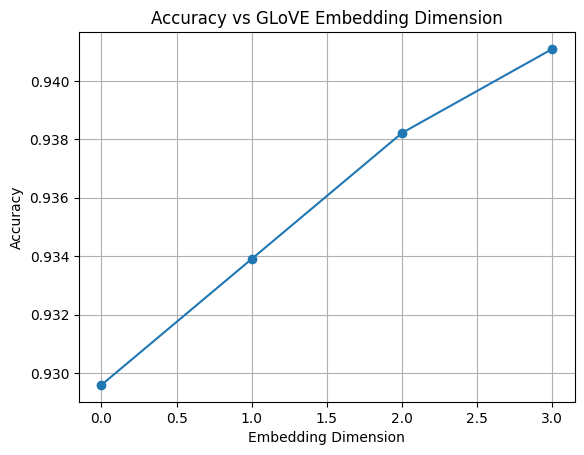

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def train_and_evaluate(X_train, X_test, y_train, y_test):
    classifier = LogisticRegression()
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"accuracy:{accuracy}")
    return accuracy

# Differnt GLoVE embeddings files
embedding_files = ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']

X_train, X_test, y_train, y_test = train_test_split(df['keywords'],df['root_label'], test_size=0.2)

accuracies = []
embedding_dimensions = []
i = 0

for file in embedding_files:
    
    embeddings = load_glove_embeddings(file)
    
    # Generate document embeddings for training and testing data
    X_train_embeddings = np.array([document_embeddings(doc, embeddings) for doc in X_train])
    X_test_embeddings = np.array([document_embeddings(doc, embeddings) for doc in X_test])
    print(f"X_train_embeddings: {len(X_train_embeddings[0])}")
    
    # Train and evaluate classifier
    accuracy = train_and_evaluate(X_train_embeddings, X_test_embeddings, y_train, y_test)
    accuracies.append(accuracy)
    
    embedding_dim = i
    i += 1
    embedding_dimensions.append(embedding_dim)
    
    print(f"Embedding Dimension: {embedding_dim}, Accuracy: {accuracy}")



## Question 13
Compare and contrast the two visualizations. Are there clusters formed in either or both of the plots? We will pursue the clustering aspect further in the next project.

### Answer:
In the 2-D visualization for GLoVE-based embeddings we can see that the two classes seened to be forming clusters. Points that belong to the same class are closer to eachother, this shows that the GLoVE-based embeddings bring similar classes closer to form clusters. Whereas, we can see that the 2-D representation of the normalized random vectors shows the data points scattered all around the two dimensnsional space. 

In [6]:
import umap
import umap.plot


In [8]:
X_train_embeddings = np.array([document_embeddings(doc, word_embeddings) for doc in x_train])
X_test_embeddings = np.array([document_embeddings(doc, word_embeddings) for doc in x_test])

glove_embedding_2d = umap.UMAP(n_components=2, metric='euclidean').fit(X_train_embeddings)

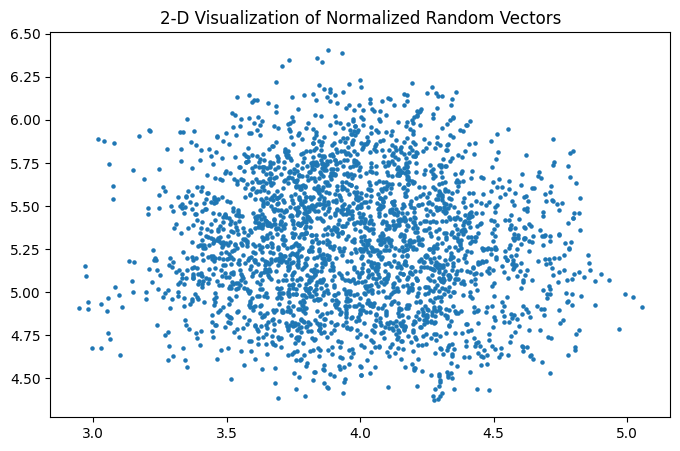

In [12]:
# for normalized random vectors
import matplotlib.pyplot as plt
random_vectors = np.random.normal(0, 1, (2780, 300))


random_vectors_norm = random_vectors / np.linalg.norm(random_vectors, axis=1)[:, np.newaxis]


umap_reducer = umap.UMAP(n_components=10, metric='cosine')
umap_embeddings = umap_reducer.fit_transform(random_vectors_norm)


plt.figure(figsize=(8, 5))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=5)
plt.title('2-D Visualization of Normalized Random Vectors')
plt.show()

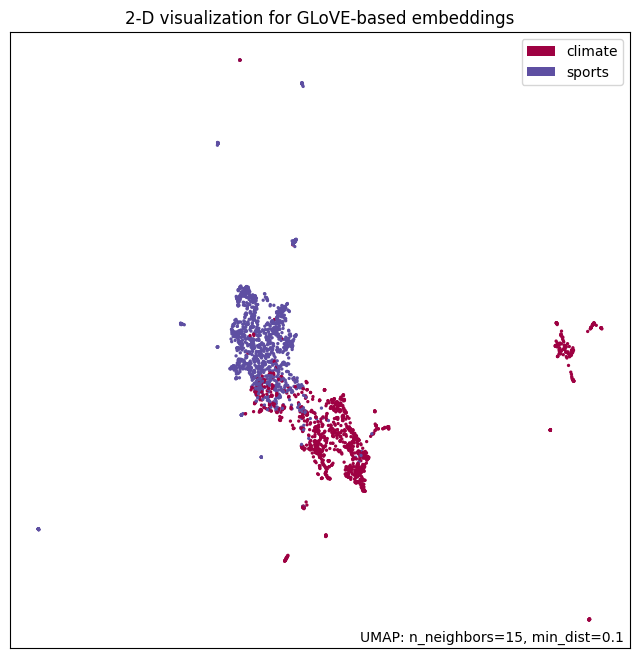

<Figure size 500x500 with 0 Axes>

In [13]:

glove = umap.plot.points(glove_embedding_2d,labels=np.array(y_train))
plt.title('2-D visualization for GLoVE-based embeddings')
plt.figure(figsize=(5, 5))
plt.show()